In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
train_losses = np.load('train_losses_v2_10.npy')
test_losses = np.load('test_losses_v2_10.npy')

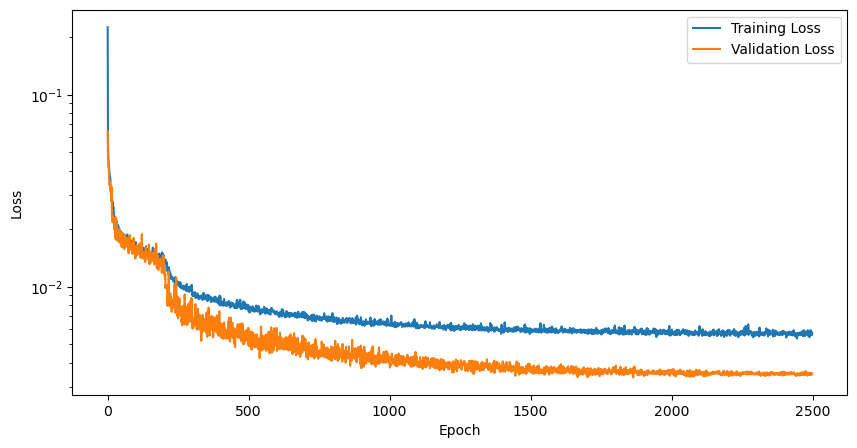

In [4]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [7]:
from train import *
import torch
predict_num = 10
train_dataset, test_dataset, n_features, n_inputs = data_preparation_v1(predict_num)
params = Params(n_features, n_inputs)
model = build_model(params)
model = torch.load('model_v2_10.pth')

File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


In [8]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [9]:
for batch in train_loader:
    x_train, y_train, u1_train, u2_train = batch

In [10]:
y_pred_scaled = model(x_train, u1_train, u2_train).detach().numpy()
y_pred = scaler_x.inverse_transform(y_pred_scaled.reshape(-1, n_features))

In [11]:
y_true = scaler_x.inverse_transform(y_train.detach().numpy().reshape(-1, n_features))

In [12]:
err = y_pred - y_true
err_norm = np.linalg.norm(err)
y_true_norm = np.linalg.norm(y_true)
ratio = err_norm / y_true_norm
print(ratio)


0.059926067


In [13]:
window_size = 150

# Data preparation
x_dataset = []
y_dataset = []
u1_dataset = []
u2_dataset = []

for suffix in range(10, 60):
    data_file_path = '../data/data_dict_' + str(suffix) + '.npy'
    
    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, y_data, u1_data, u2_data = load_dataset(data_dict)
        x_dataset.append(x_data[:window_size])
        y_dataset.append(y_data[:window_size])
        u1_dataset.append(u1_data[:window_size])
        u2_dataset.append(u2_data[:window_size])
    else:
        print(f"File not found: {data_file_path}")

"""
x_data.shape = (n_samples, n_features)
y_data.shape = (n_samples, n_features)
u1_data.shape = (n_samples, n_inputs)
u2_data.shape = (n_samples, n_inputs)
"""


File not found: ../data/data_dict_25.npy
File not found: ../data/data_dict_44.npy


'\nx_data.shape = (n_samples, n_features)\ny_data.shape = (n_samples, n_features)\nu1_data.shape = (n_samples, n_inputs)\nu2_data.shape = (n_samples, n_inputs)\n'

In [18]:
# start from the zero point
y_data_pred_50traj_10predict = []
for x_data, u1_data, u2_data in zip(x_dataset, u1_dataset, u2_dataset):
    steps = int(150 / predict_num)
    n_target = x_data.shape[1]
    x_data_scaled = scaler_x.transform(x_data)
    u1_data_scaled = scaler_u.transform(u1_data)
    u2_data_scaled = scaler_u.transform(u2_data)
    y_data_pred_scaled = [torch.tensor(x_data_scaled[0:predict_num,:], dtype = torch.float32)]
    for step in range(steps - 1):
        # print(step)
        x = torch.tensor(y_data_pred_scaled[-1].reshape((1, predict_num, -1)),dtype = torch.float32)
        u1 = torch.tensor(u1_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        u2 = torch.tensor(u2_data_scaled[predict_num * step: predict_num * (step + 1), :].reshape((1, predict_num, -1)), dtype = torch.float32)
        y_pred = model(x, u1, u2)
        y_data_pred_scaled.append(y_pred.reshape(predict_num, -1))
    y_data_pred_scaled = torch.cat(y_data_pred_scaled, dim = 0).detach().numpy()
    # print(np.shape(y_data_pred_scaled))
    y_data_pred = scaler_x.inverse_transform(y_data_pred_scaled)
    y_data_pred_50traj_10predict.append(y_data_pred)


In [19]:
x_dataset[0][10:20,:]

array([[-0.09944579, -0.01042068,  0.00193784, ...,  0.00335516,
         0.00257824,  0.00295277],
       [-0.0992718 , -0.01040246,  0.00193445, ...,  0.00364093,
         0.00283564,  0.00191329],
       [-0.0989043 , -0.01036395,  0.00192728, ...,  0.0038264 ,
         0.00300423,  0.00114789],
       ...,
       [-0.09018712, -0.00945036,  0.00175707, ...,  0.0037637 ,
         0.0030019 , -0.00165389],
       [-0.08655633, -0.00906983,  0.00168617, ...,  0.00361298,
         0.00288811, -0.00229873],
       [-0.0819728 , -0.00858947,  0.00159667, ...,  0.00344143,
         0.00276027, -0.00308879]])

In [20]:
y_data_pred_50traj_10predict[0][10:20,:]

array([[-0.01385478, -0.00145084,  0.00026649, ...,  0.00850002,
         0.00765314, -0.03671662],
       [-0.03340112, -0.00349923,  0.00064805, ...,  0.00769447,
         0.00683238, -0.0295999 ],
       [-0.04850014, -0.00508157,  0.00094284, ...,  0.00698299,
         0.00611762, -0.02367705],
       ...,
       [-0.10288022, -0.01078057,  0.00200488, ...,  0.00365304,
         0.00284601,  0.00119443],
       [-0.10962334, -0.01148725,  0.00213659, ...,  0.00317612,
         0.00238206,  0.00456551],
       [-0.11421944, -0.01196892,  0.00222636, ...,  0.00284572,
         0.00206087,  0.00689101]], dtype=float32)

In [21]:
errors = [y_data_pred_50traj_10predict[i] - x_dataset[i][:(steps * predict_num), :] for i in range(len(y_data_pred_50traj_10predict))]

error_norms = [np.linalg.norm(errors[i], axis=1) for i in range(len(errors))]

data_norms = [np.linalg.norm(x_dataset[i][:steps, :]) for i in range(len(x_dataset))]

relative_errors = [error_norms[i] / data_norms[i] for i in range(len(errors))] 

In [22]:
mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

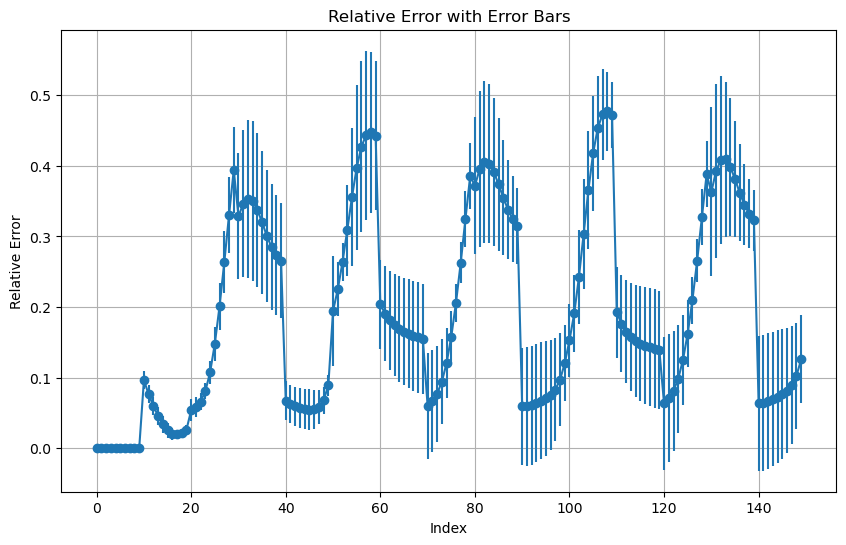

In [23]:
# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps * predict_num), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Index')
plt.ylabel('Relative Error')
plt.title('Relative Error with Error Bars')
plt.grid(True)
plt.show()

In [24]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]

In [25]:
np.mean(domain_relative_error)

2.9929668224353008

In [26]:
x_dataset[0].shape

(150, 6957)

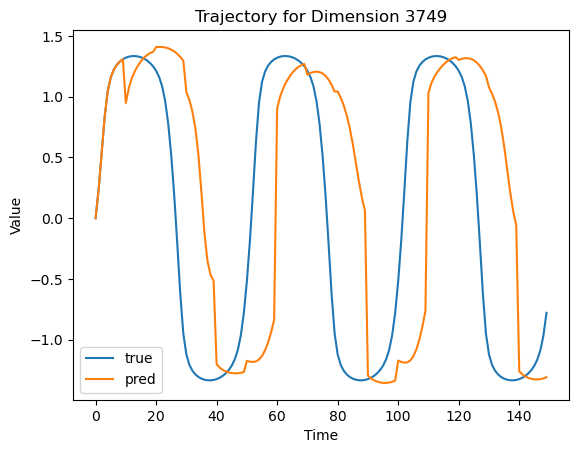

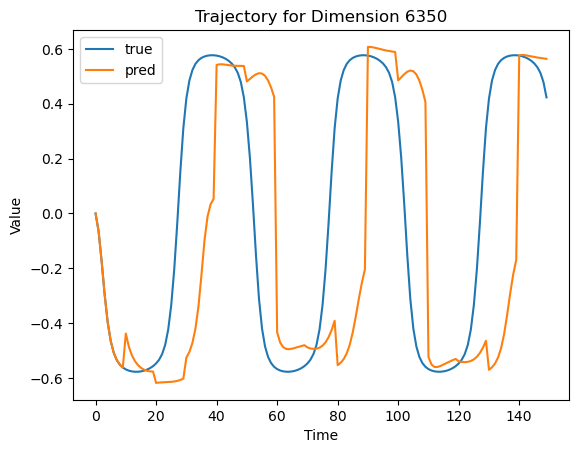

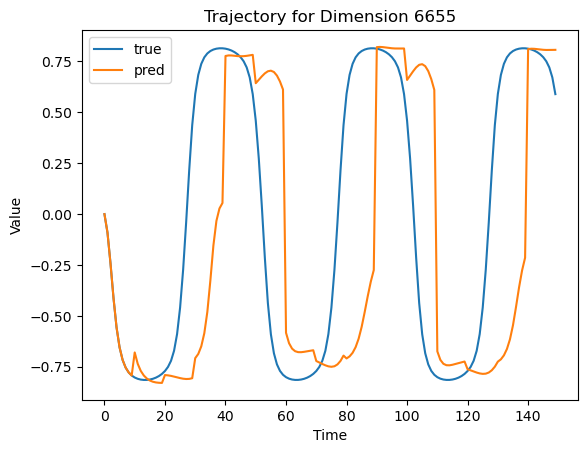

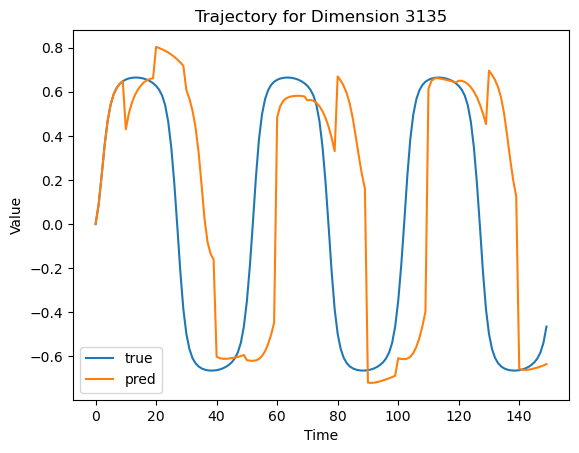

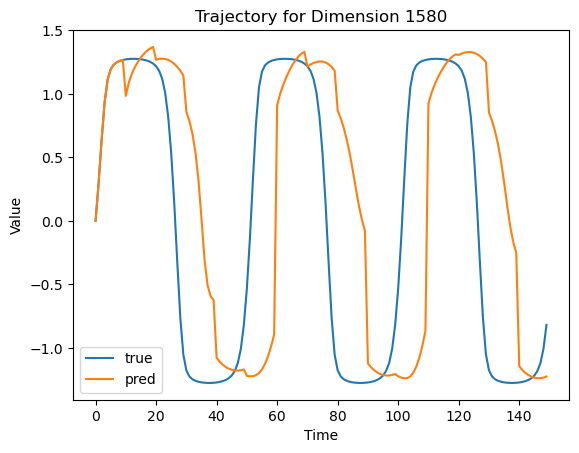

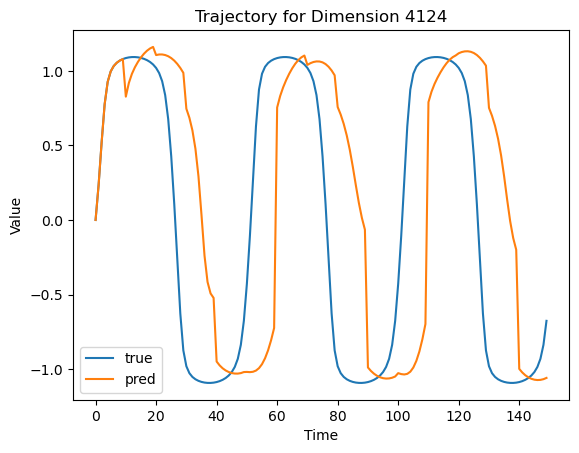

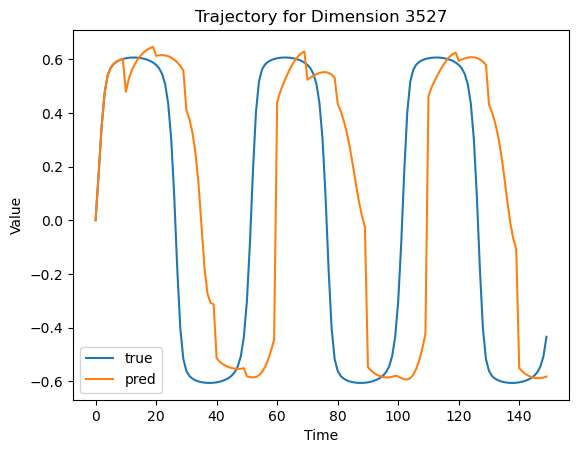

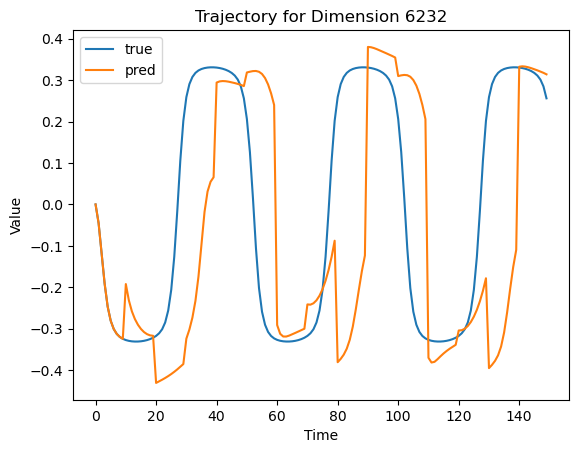

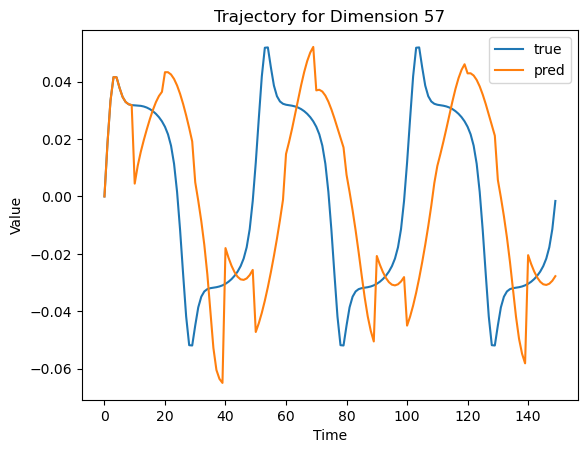

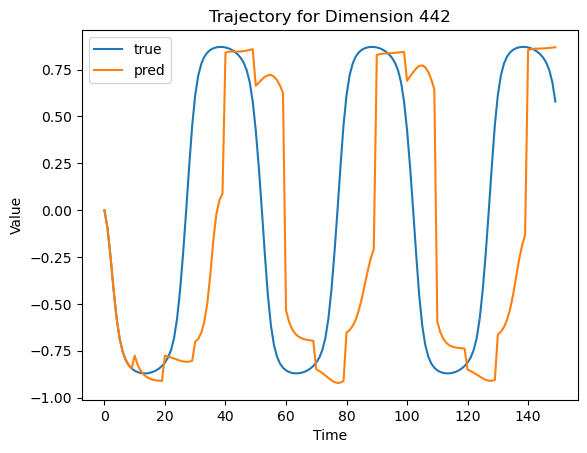

In [27]:
import numpy as np
import matplotlib.pyplot as plt

n_dimensions = x_dataset[0].shape[1]
selected_dimensions = np.random.choice(n_dimensions, 10, replace=False)

for i in selected_dimensions:
    plt.figure()
    y_true = x_dataset[0]
    y_pred = y_data_pred_50traj_10predict[0]
    plt.plot(y_true[:, i], label = 'true')
    plt.plot(y_pred[:, i], label = 'pred')
    plt.title(f'Trajectory for Dimension {i}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()